"""  
made by Kataoka @2023/10/XX.  
  
This is tutorial for PINNs and PyTorch.  
Build a model for predicting 2D cavity flow.  
"""  

とぅどぅ

sample_points_cavity
・動きはするが書き方が汚すぎる．もう少しきれいな書き方を模索したい（１行が長い）
・離散時間に対する処理を書く
・docstringを書く

plot_residual3D
・辞書データに対する属性付与の方法を考える
・docstring

Phisics_Informed_NN
・なんでも良いから手を動かす（やらないとわからない）

# Import Libraries

In [2]:
# Standard Library

import os
import sys
import glob
import matplotlib.pyplot as plt

# External Library
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

# Settings

In [ ]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
# device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data

In [24]:
def sample_points_cavity(
    num_sampling = 200000,
    num_sampling_left_edge = 10000,
    num_sampling_right_edge = 10000,
    num_sampling_bottom_edge = 10000,
    num_sampling_top_edge = 10000,
    num_sampling_init = 10000,
    continuous_time=True,
    size = 1,
    maxtime = 10,
    dt = 0.1
):
    """
    docstring
        
    """

    points_dict = {}

    points = np.empty(shape=(0,3))
    points_left_edge = np.empty(shape=(0,3))
    points_right_edge = np.empty(shape=(0,3))
    points_bottom_edge = np.empty(shape=(0,3))
    points_top_edge = np.empty(shape=(0,3))

    if continuous_time==True:
        # within the region
        points_dict["residual"] = sample_from_Rectangular(num_sampling=num_sampling, x_size=size, y_size=size, z_size=maxtime)
        
        # boundary
        temp_array = sample_from_Square(num_sampling=num_sampling_left_edge, x_size=size, y_size=maxtime)
        points_dict["left_edge"] = \
            np.concatenate([temp_array[:,0:1], np.full((num_sampling_left_edge, 1), 0), temp_array[:,1:2]], axis=1)
        
        temp_array = sample_from_Square(num_sampling=num_sampling_right_edge, x_size=size, y_size=maxtime)
        points_dict["right_edge"] = \
            np.concatenate([temp_array[:,0:1], np.full((num_sampling_right_edge, 1), size), temp_array[:,1:2]], axis=1)
        
        temp_array = sample_from_Square(num_sampling=num_sampling_bottom_edge, x_size=size, y_size=maxtime)
        points_dict["bottom_edge"] = np.concatenate([np.full((num_sampling_bottom_edge, 1), 0), temp_array], axis=1)
        
        temp_array = sample_from_Square(num_sampling=num_sampling_top_edge, x_size=size, y_size=maxtime)
        points_dict["top_edge"] = np.concatenate([np.full((num_sampling_top_edge, 1), size), temp_array], axis=1)

        # initial
        temp_array = sample_from_Square(num_sampling=num_sampling_init, x_size=size, y_size=size)
        points_dict["init"] = np.concatenate([temp_array, np.full((num_sampling_init, 1), 0)], axis=1)

    else:
        pass
    
    return points_dict



def sample_from_Rectangular(
    num_sampling, 
    x_size,
    y_size,
    z_size,
    x_min = 0,
    y_min = 0,
    z_min = 0
):
    """
    sample points from recranglar region.
    
    Args:
        num_sampling : int / number of sampling points
        x_size : int or float / rectangular length for x
        y_size : int or float / rectangular length for y
        z_size : int or float / rectangular length for z
        x_min = 0 : int or float / minimum value of x sampling range. sample from [x_min, x_min+x_size]
        y_min = 0 : int or float / minimum value of y sampling range. sample from [y_min, y_min+y_size]
        z_min = 0 : int or float / minimum value of z sampling range. sample from [z_min, z_min+z_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    
    points_array = np.random.rand(num_sampling, 3)
    
    size_array = \
        np.concatenate([np.full((num_sampling, 1),x_size), np.full((num_sampling, 1),y_size), np.full((num_sampling, 1),z_size)], axis=1)
    min_array = \
        np.concatenate([np.full((num_sampling, 1),x_min), np.full((num_sampling, 1),y_min), np.full((num_sampling, 1),z_min)], axis=1)

    return points_array * size_array - min_array



def sample_from_Square(
    num_sampling, 
    x_size,
    y_size,
    x_min = 0,
    y_min = 0,
):
    """
    sample points from square region.

    Args:
        num_sampling : int / number of sampling points
        x_size : int or float / rectangular length for x
        y_size : int or float / rectangular length for y
        x_min : int or float / minimum value of x sampling range. sample from [x_min, x_min+x_size]
        y_min : int or float / minimum value of y sampling range. sample from [y_min, y_min+y_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    
    points_array = np.random.rand(num_sampling, 2)
    
    size_array = np.concatenate([np.full((num_sampling, 1),x_size), np.full((num_sampling, 1),y_size)], axis=1)
    min_array = np.concatenate([np.full((num_sampling, 1),x_min), np.full((num_sampling, 1),y_min)], axis=1)

    return points_array * size_array - min_array



def sample_from_Line(
    num_sampling, 
    x_size,
    x_min = 0,
):
    """
    sample points from line region.

    Args:
        num_sampling : int or float / number of sampling points
        x_size : int or float / rectangular length for x
        x_min : int or float / minimum value of x sampling range. sample from [x_min, x_min+x_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    
    points_array = np.random.rand(num_sampling, 1)
    
    size_array = np.concatenate([np.full((num_sampling, 1),x_size)], axis=1)
    min_array = np.concatenate([np.full((num_sampling, 1),x_min)], axis=1)

    return points_array * size_array - min_array

# Visualization

In [26]:
def plot_residual3D(
    data,
    region_map
):
    """

    """
    
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection="3d")
    
    ax.set_xlabel("x", size = 14)
    ax.set_ylabel("t", size = 14)
    ax.set_zlabel("y", size = 14)
    
    c_map = ["black", "blue", "green", "red"]
    
    for i,key in enumerate(list(data.keys())):
        ax.scatter(data[key][:,0], data[key][:,2], data[key][:,1], s=0.1, color=c_map[region_map[i]])
        
    plt.show()
    
    return

In [27]:
a = sample_points_cavity()

# Physucs-Informed Neural Networks

In [ ]:
class Phisics_Informed_NN(nn.Module):
    """
    PyTorchわからん；；
    """
    def __init__(self, input_size, output_size, num_layer, num_neuron):
        
        super(Phisics_Informed_NN, self).__init__()
        
        # 
        self.input_size = input_size
        self.output_size = output_size
        self.num_layer = num_layer
        self.num_neuron = num_neuron

        # 
        self.inputs = nn.Linear(input_size, num_neuron)
        self.outputs = nn.Linear(num_neuron, output_size)
        self.fc = nn.Linear(num_neuron, num_neuron)
        
    def forward(self, x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)    
        
        x = self.inputs(x)
        
        for 
        x = self.hidden_layer(x, num_layer-1, num_neuron)
        x = self.outputs(x)
        
        #x = self.inputs(x)
        #x = self.hidden_layer(x, num_layer-1, num_neuron)
        #x = self.outputs(x)
        
        return x
        
    def hidden_layer(self, x, remaining_layer, num_neuron):
        
        if remaining_layer==0:
            return x
        elif remaining_layer>0:
            x = self.hidden_layer(x, remaining_layer, num_neuron)
            return self.fc(x)
        else:
            

# Main

# Test and Debug

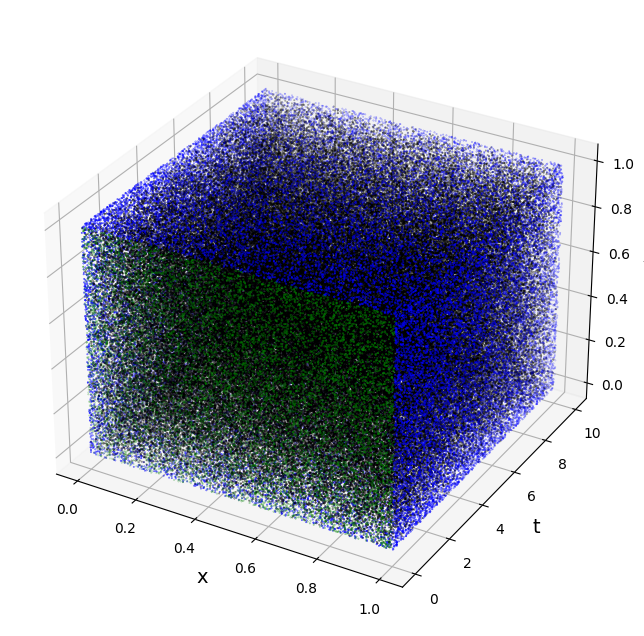

In [28]:
plot_residual3D(a, [0,1,1,1,1,2])

In [17]:
import numpy as np

points = np.random.rand(1000,2)

In [18]:
points[:,0]

array([5.52894698e-01, 2.35282224e-01, 7.44197336e-02, 8.49953140e-01,
       4.85646271e-01, 7.71779073e-01, 1.99615601e-01, 2.32797339e-02,
       4.83768196e-01, 2.63329122e-01, 2.83301602e-01, 2.27931968e-01,
       8.34044646e-01, 8.96339790e-01, 1.48862530e-01, 7.38387131e-02,
       3.30054799e-01, 9.20062740e-01, 9.37025032e-01, 7.71703911e-02,
       1.35565499e-01, 6.61864661e-01, 4.88681754e-01, 8.11562128e-01,
       2.76795382e-01, 4.06666211e-01, 2.54795708e-01, 2.12084254e-01,
       6.65499762e-01, 5.60442763e-01, 9.12379333e-01, 1.27895345e-01,
       7.81756071e-01, 9.27299448e-01, 3.13468882e-01, 6.21728898e-01,
       5.47500531e-02, 8.27954313e-01, 9.74114585e-01, 7.82134316e-01,
       9.55414031e-01, 9.17090422e-01, 7.03614074e-01, 6.87876158e-02,
       8.41309396e-01, 9.04574111e-01, 2.78596139e-02, 9.72970768e-01,
       7.43400338e-01, 5.04312664e-02, 6.82904606e-01, 5.10559570e-02,
       4.10561161e-01, 9.31002885e-01, 7.94911591e-01, 5.88895825e-01,
      

In [19]:
points

array([[0.5528947 , 0.45398244, 0.73844449],
       [0.23528222, 0.63728106, 0.7963812 ],
       [0.07441973, 0.84346266, 0.92731579],
       ...,
       [0.01475766, 0.62802617, 0.79137086],
       [0.38467564, 0.4812638 , 0.90685969],
       [0.10729592, 0.88910976, 0.26367764]])

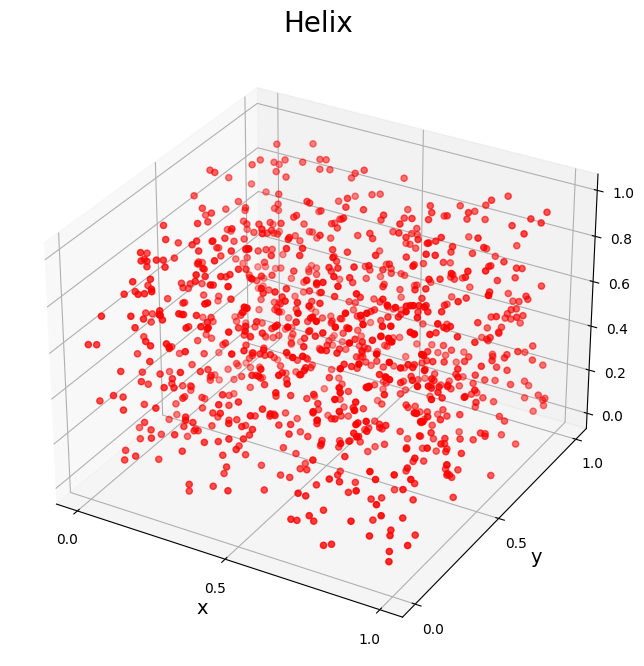

In [20]:
# PYTHON_MATPLOTLIB_3D_PLOT_01

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Figureを追加
fig = plt.figure(figsize = (8, 8))

# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# Axesのタイトルを設定
ax.set_title("Helix", size = 20)

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("y", size = 14)
ax.set_zlabel("z", size = 14)

# 軸目盛を設定
ax.set_xticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])

# 円周率の定義
pi = np.pi

# パラメータ分割数
n = 256

# パラメータtを作成
#t = np.linspace(-6*pi, 6*pi, n)

# らせんの方程式
#x = np.cos(t)
#y = np.sin(t)
#z = t

# 曲線を描画
#ax.plot(x, y, z, color = "red")
ax.scatter(points[:,0], points[:,1], points[:,2], color = "red")

plt.show()

In [3]:
points_array = np.empty(shape=(0,3))

for i in range(2):
    points_array = np.concatenate([points_array, np.random.rand(1,3)])

In [4]:
points_array

array([[0.78915547, 0.08259345, 0.89614248],
       [0.54591416, 0.47039771, 0.60032514]])

In [5]:
np.concatenate([points_array, points_array], axis=1)

array([[0.78915547, 0.08259345, 0.89614248, 0.78915547, 0.08259345,
        0.89614248],
       [0.54591416, 0.47039771, 0.60032514, 0.54591416, 0.47039771,
        0.60032514]])

# Industrial Waste

In [ ]:
def sample_from_Rectangular(
    num_sampling, 
    x_size,
    y_size,
    z_size,
    x_min = 0,
    y_min = 0,
    z_min = 0
):
    """
    sample points from recranglar region.
    
    Args:
        num_sampling : int / number of sampling points
        x_size : int or float / rectangular length for x
        y_size : int or float / rectangular length for y
        z_size : int or float / rectangular length for z
        x_min = 0 : int or float / minimum value of x sampling range. sample from [x_min, x_min+x_size]
        y_min = 0 : int or float / minimum value of y sampling range. sample from [y_min, y_min+y_size]
        z_min = 0 : int or float / minimum value of z sampling range. sample from [z_min, z_min+z_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    
    points_array = np.empty(shape=(0,3))

    for i in range(num_sampling):
        new_data = np.random.rand(1,3) * np.array([[x_size, y_size, z_size]]) - np.array([[x_min, y_min, z_min]])
        points_array = np.concatenate([points_array, new_data], axis=0)

    return points_array



def sample_from_Square(
    num_sampling, 
    x_size,
    y_size,
    x_min = 0,
    y_min = 0,
):
    """
    sample points from square region.

    Args:
        num_sampling : int / number of sampling points
        x_size : int or float / rectangular length for x
        y_size : int or float / rectangular length for y
        x_min : int or float / minimum value of x sampling range. sample from [x_min, x_min+x_size]
        y_min : int or float / minimum value of y sampling range. sample from [y_min, y_min+y_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    
    points_array = np.empty(shape=(0,2))

    for i in range(num_sampling):
        new_data = np.random.rand(1,2) * np.array([[x_size, y_size]]) - np.array([[x_min, y_min]])
        points_array = np.concatenate([points_array, new_data], axis=0)

    return points_array



def sample_from_Line(
    num_sampling, 
    x_size,
    x_min = 0,
):
    """
    sample points from line region.

    Args:
        num_sampling : int or float / number of sampling points
        x_size : int or float / rectangular length for x
        x_min : int or float / minimum value of x sampling range. sample from [x_min, x_min+x_size]

    Returns:
        points_array: np.ndarray / set of points
    """

    
    points_array = np.empty(shape=(0,1))

    for i in range(num_sampling):
        new_data = np.random.rand(1,1) * np.array([[x_size]]) - np.array([[x_min]])
        points_array = np.concatenate([points_array, new_data], axis=0)

    return points_array